<a href="https://colab.research.google.com/github/hcgalvan/labodedatos/blob/main/Ejercitacion_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instrucciones Generales del Proyecto

**Instrucciones**

El objetivo de la segunda ejercitación obligatoria es predecir el uso de anticoncepción en base a datos demográficos. 

> El problema es predecir el uso de anticonceptivos en la muestra (ningún método vs. métodos de corto o largo plazo).

Atributos:

1. Edad de la mujer (numérico)
2. Educación de la mujer (ordinal, 1=bajo, 2, 3, 4=alto)
3. Educación del hombre (ordinal, 1=bajo, 2, 3, 4=alto)
4. Número de hijos nacidos (numérico)
5. Religión de la mujer (binario, 1=Islam, 0= No islam)
6. ¿Trabaja la mujer? (binario, 1=Sí, 0=No)
7. Ocupación del hombre (categórico, 1,2,3,4)
8. Índice de nivel de vida (ordinal, 1=bajo, 2, 3, 4=alto)
9. Exposición a medios (binario, 1=Sí, 0=No)
10. Método anticonceptivo utilizado (categórico, 1=No usa, 2=Largo plazo, 3=Corto plazo)

**El objetivo es dicotomizar la variable 10** entre No usa (1) vs. Largo o corto plazo (2 o 3) y predecir la variable binaria resultante.

---

Ustedes van a bajar los datos, entrenar un modelo basado en regresión logística, optimizarlo, etc., usando las herramientas que vimos en la clase.

Luego, les vamos a pasar datos sin etiquetas y ustedes estimarán la probabilidad de que la etiqueta sea positiva (uso de anticoncepción). 

Finalmente, nosotros usaremos esa información para calcular un AUC y rankearlos de acuerdo a la performance de sus modelos. Publicaremos el top 10 únicamente, y los primeros tres tendrán premios fantásticos. Además, serán invitados a mostrar sus notebooks y contar sus modelos.

La fecha límite para el desarrollo de modelos es el día 7 de Mayo. Ese día les pasamos los datos y nos devuelven las probabilidades.


# Conexion con Datos

In [29]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos
from sklearn.metrics import confusion_matrix # matriz de confusion
import seaborn as sbn # Herramienta complementaria de visualización https://seaborn.pydata.org/

In [4]:
# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/Practico2-anticoncepcion_indonesia.csv'

d = pd.read_csv(filename) # Levantamos los datos, en este caso, con el método pd.read_excel
d.head() # Mostramos las primeras líneas, para darnos una idea

Mounted at /content/drive


,edad_mujer,educacion_mujer,educacion_hombre,numero_hijos,religion_mujer,mujer_trabaja,ocupacion_hombre,nivel_vida,exposicion_medios,metodo_anticonceptivo
0,35,3,4,3,1,1,2,2,0,2
1,29,4,4,3,1,1,1,4,0,2
2,21,4,4,1,1,1,2,3,0,3
3,26,3,4,3,1,1,3,2,0,3
4,45,3,4,6,1,1,2,4,0,1


# Regresión Logística - Clasificación

Algunos detalles a tener en cuenta.
Elección de variables a considerar en modelo

1.   El Islam no acepta anticonceptivos, excepto salvar la vida de la mujer.( “Si se planifica por motivos de dinero, no es aceptable, si se hace por motivos emocionales o de salud, sí”. Eso sí, siempre que ya se haya tenido, al menos, un niño y una niña )
2.   Ser pobre no es excusa para usar anticonceptivos ("Pero parar de tener hijos porque no tienes dinero... Odiamos eso, estamos en contra).
3. otra razón: la libertad de elección personal de la mujer, relegada a un segundo plano: necesita el consentimiento, cuando no la decisión, del marido y/o del rabino, en este caso.

Fuente:
 https://medicamentalia.org/anticonceptivos/religion/#:~:text=El%20m%C3%A9todo%20anticonceptivo%20informal%2C%20para,%E2%80%A6%E2%80%9D%2C%20calcula%20Ousman%20M.



In [5]:
d_filtrado = d[['edad_mujer',
                'educacion_mujer',
                'educacion_hombre',
                'numero_hijos',
                'religion_mujer',
                'mujer_trabaja',
                'ocupacion_hombre',
                'nivel_vida',
                'exposicion_medios',
                'metodo_anticonceptivo']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename({'edad_mujer' : 'edadmuj',
                   'educacion_mujer' : 'educmuj',
                   'educacion_hombre' : 'educhom',
                   'numero_hijos' : 'hijos',
                   'religion_mujer' : 'religmuj',
                   'mujer_trabaja' : 'trabamuj',
                   'ocupacion_hombre' : 'ocupahom',
                   'nivel_vida' : 'nivelvid',
                   'exposicion_medios' : 'exposmed',                                                                            
                   'metodo_anticonceptivo' : 'metodoant'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

In [6]:
d_filtrado.head()

,edadmuj,educmuj,educhom,hijos,religmuj,trabamuj,ocupahom,nivelvid,exposmed,metodoant
0,35,3,4,3,1,1,2,2,0,2
1,29,4,4,3,1,1,1,4,0,2
2,21,4,4,1,1,1,2,3,0,3
3,26,3,4,3,1,1,3,2,0,3
4,45,3,4,6,1,1,2,4,0,1


Teniendo en cuenta que queremos saber si entre No usa (1) vs. Largo o corto plazo (2 o 3) y predecir la variable binaria resultante, vamos a llevar a una categoría binaria la columna "metodoant".

Generemos una nueva columna que sea "UsaNousa" que de cuenta de esto.
Para ello el valor de columna UsaNOusa estará dada por

*   = 0 indicará que utiliza métodos anticonceptivos y
*   = 1 indicará que NO utiliza métodos anticonceptivos



In [7]:
d_filtrado['UsaNousa'] = 1 # empezamos con una columna llena de 1. 
indice =  d_filtrado['metodoant'] > 1  # esto me da los valores del indice para los cuales ha utilizado metodo anticonceptivo mayor a 1
d_filtrado.loc[indice, 'UsaNousa'] = 0 # entonces para esos valores del indice pongo 0, porque ha utilizado métodos anticonceptivos

d_filtrado['UsaNousa'].value_counts()

0    165
1    131
Name: UsaNousa, dtype: int64

Para probar el modelo, utilizaré tres campos: Religion, Cantidad de hijos y educacion del hombre

In [8]:
d_filtrado.head()

,edadmuj,educmuj,educhom,hijos,religmuj,trabamuj,ocupahom,nivelvid,exposmed,metodoant,UsaNousa
0,35,3,4,3,1,1,2,2,0,2,0
1,29,4,4,3,1,1,1,4,0,2,0
2,21,4,4,1,1,1,2,3,0,3,0
3,26,3,4,3,1,1,3,2,0,3,0
4,45,3,4,6,1,1,2,4,0,1,1


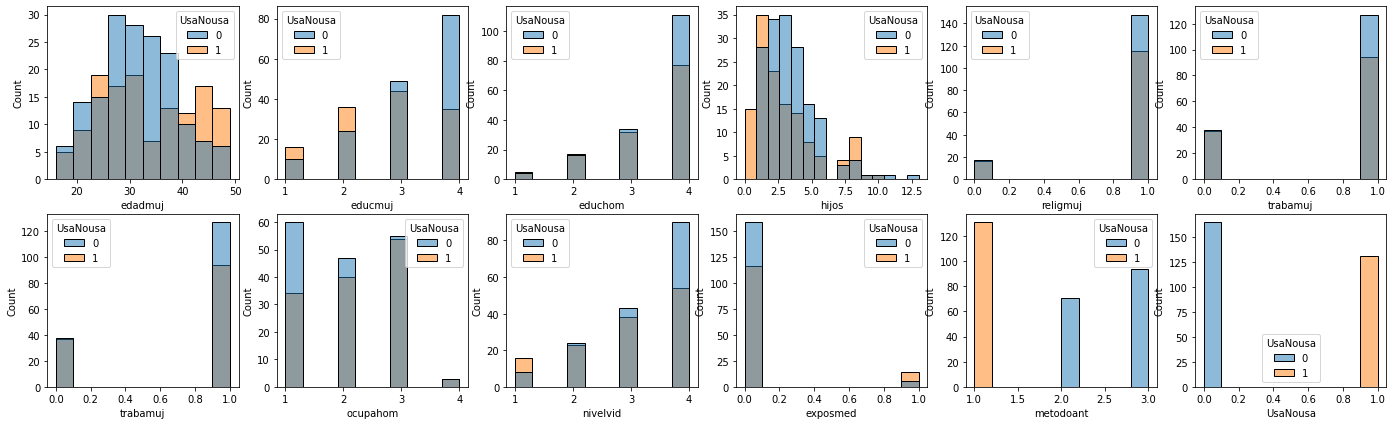

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(24,7))
for i in np.arange(0,6,1):
    sbn.histplot(data=d_filtrado, x=d_filtrado.columns[i], hue=y, ax = axs[0,i])
    axs[0,i].set_xlabel(d_filtrado.columns[i])
    sbn.histplot(data=d_filtrado, x=d_filtrado.columns[i+5], hue=y, ax=axs[1,i])
    axs[1,i].set_xlabel(d_filtrado.columns[i+5])


# Modelo 1

d_filtrado.rename({'edad_mujer' : 'edadmuj',
                   'educacion_mujer' : 'educmuj',
                   'educacion_hombre' : 'educhom',
                   'numero_hijos' : 'hijos',
                   'religion_mujer' : 'religmuj',
                   'mujer_trabaja' : 'trabamuj',
                   'ocupacion_hombre' : 'ocupahom',
                   'nivel_vida' : 'nivelvid',
                   'exposicion_medios' : 'exposmed',                                                                            
                   'metodo_anticonceptivo' : 'metodoant'},

Defino la función necesaria para calcular el balanced accuracy.

In [21]:
def balanced_accuracy(cm): # funcion para calcular la "balanced accuracy"
  sensibilidad = cm[1,1]/(cm[1,1]+cm[0,1])
  especificidad = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensibilidad, especificidad, (sensibilidad + especificidad)/2]

Ahora vamos a usar cinco variables, primero sin ningún tipo de transformación

In [43]:
from sklearn.preprocessing import MinMaxScaler

# Definamos la matriz X
campos = ['edadmuj', 'religmuj', 'hijos', 'educmuj', 'ocupahom'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
print(X.shape) # Como vemos, es una matriz de 1054 filas y 2 columnas
y = d_filtrado['UsaNousa'] # Nuestra etiqueta sigue siende la misma de antes

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
score = regLog.score(X,y) # Calculamos el score

ypred = regLog.predict(X) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

(296, 5)
El score del modelo es de: 0.7264
Matriz de confusion del modelo es:
[[121  37]
 [ 44  94]]
Sensibilidad del modelo es de: 0.7176
Especificidad del modelo es de: 0.7333
BA del modelo es de: 0.7254


vamos a empezar a aumentar el espacio de features, primero agregando los términos cuadráticos y cúbicos:

In [23]:
X_1 = np.concatenate((X, X**2,X**3,X**4, X**5), axis=1)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_1) # encuentro los parametros para el escaleo
X_1 = scaler.transform(X_1) # aplico la transformacion

regLog_1 = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
regLog_1.fit(X_1, y) # Ajustamos el modelo con los parámetros
score = regLog_1.score(X_1,y) # Calculamos el score

ypred = regLog_1.predict(X_1) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm = confusion_matrix(ypred, y) # primera entrada son las etiquetas predichas, segunda son las reales
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas[2],4))) 

El score del modelo es de: 0.7331
Matriz de confusion del modelo es:
[[126  40]
 [ 39  91]]
Sensibilidad del modelo es de: 0.6947
Especificidad del modelo es de: 0.7636
BA del modelo es de: 0.7291


# Train - test Split

Una forma de hacer esto es separar parte de los datos para entrenar el modelo (obtener los parámetros) y dejar otra parte para evaluar la performance del modelo. Al hacer eso, tengo las siguientes posibilidades,


1.   La performance es baja en el set de entrenamiento y baja en el set de evaluación. En este caso, necesito o más datos, o más features (puedo probar agregar features que ya tenía transformándolos).
2.   La performance es alta en el set de entrenamiento y baja en el set de evaluación. En este caso, estoy sobreajustando. Puedo intentar resolver esto sumando más datos a mi modelo, o bien aplicando regularización.
3. La performance es alta en el set de entrenamiento y alta en el set de evaluación. El caso ideal: aprendí parámetros que me sirven para generalizar a datos nuevos sin sobreajustar.


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

#### IMPORTANTE: HAGO LA NORMALIZACION DE LOS DATOS POR SEPARADO EN LOS SETS DE TRAIN Y TEST

regLog = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog.score(X_train,y_train) # Calculamos el score
ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_train[2],4))) 
print('\n')

score_test= regLog.score(X_test,y_test) # Calculamos el score
ypred_test= regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_test[2],4))) 

Para TRAIN set:
El score del modelo es de: 0.7198
Matriz de confusion del modelo es:
[[86 26]
 [32 63]]
Sensibilidad del modelo es de: 0.7079
Especificidad del modelo es de: 0.7288
BA del modelo es de: 0.7183


Para TEST set:
El score del modelo es de: 0.6966
Matriz de confusion del modelo es:
[[39 19]
 [ 8 23]]
Sensibilidad del modelo es de: 0.5476
Especificidad del modelo es de: 0.8298
BA del modelo es de: 0.6887


¿Y si vamos al caso con features polinómicos agregados?

In [36]:
# Definamos la matriz X
campos = ['edadmuj', 'religmuj', 'hijos', 'educmuj', 'ocupahom'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos

X_temp = X
for i in np.arange(2,5):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp
 
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

regLog_1 = LogisticRegression(penalty = 'none', class_weight='balanced', max_iter=50000) # Inicializamos nuevamente el modelo
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog_1.score(X_train,y_train) # Calculamos el score
ypred_train = regLog_1.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_train[2],4))) 
print('\n')

score_test= regLog_1.score(X_test,y_test) # Calculamos el score
ypred_test= regLog_1.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_test[2],4))) 

Para TRAIN set:
El score del modelo es de: 0.715
Matriz de confusion del modelo es:
[[87 27]
 [32 61]]
Sensibilidad del modelo es de: 0.6932
Especificidad del modelo es de: 0.7311
BA del modelo es de: 0.7121


Para TEST set:
El score del modelo es de: 0.6404
Matriz de confusion del modelo es:
[[27 13]
 [19 30]]
Sensibilidad del modelo es de: 0.6977
Especificidad del modelo es de: 0.587
BA del modelo es de: 0.6423


In [37]:
# Definamos la matriz X
campos = ['edadmuj', 'religmuj', 'hijos', 'educmuj', 'ocupahom'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos


X_temp = X
for i in np.arange(2,5):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp
 

X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

regLog_1 = LogisticRegression(penalty = 'l2', class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog_1.score(X_train,y_train) # Calculamos el score
ypred_train = regLog_1.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_train[2],4))) 
print('\n')

score_test= regLog_1.score(X_test,y_test) # Calculamos el score
ypred_test= regLog_1.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))  
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))  
print('BA del modelo es de: {}'.format(round(metricas_test[2],4))) 

Para TRAIN set:
El score del modelo es de: 0.686
Matriz de confusion del modelo es:
[[81 27]
 [38 61]]
Sensibilidad del modelo es de: 0.6932
Especificidad del modelo es de: 0.6807
BA del modelo es de: 0.6869


Para TEST set:
El score del modelo es de: 0.6854
Matriz de confusion del modelo es:
[[31 13]
 [15 30]]
Sensibilidad del modelo es de: 0.6977
Especificidad del modelo es de: 0.6739
BA del modelo es de: 0.6858


# Optimización de Hiperparámetros

Tiene sentido hacer la siguiente pregunta: ¿para qué elección de hiperparámetros **maximizo** la performance del clasificador en el dataset de evaluación (test)?

Vamos a proponer la siguiente forma de abordar este problema:

1. Generamos una función que entrene y evalue el clasificador usando un train-test split, que incorpore como input los hiperparámetros
2. Para cada elección del par de hiperparámetros, repetimos este procedimiento unas cuantas (>100) veces y nos quedamos con la performance promedio. Esto es necesario porque el train-test split es aleatorio.
3. Repetimos para todas las combinaciones de nuestros hiperparámetros y encontramos aquella que maximiza la performance del clasificador.

In [47]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  X_temp = X
  for i in np.arange(2,n):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
  X = X_temp
 
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=10000) 
  regLog.fit(X_train, y_train) 
  
  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

Probando algunos casos particulares y veamos como depende del azar.

In [51]:
campos = ['edadmuj', 'religmuj', 'hijos', 'educmuj', 'ocupahom'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = d_filtrado['UsaNousa'] # Nuestra etiqueta sigue siende la misma de antes

n_values = np.arange(1,5) # rango de potencias maximas 
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 100 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)

[1, 0.2]
[1, 0.4]
[1, 0.6000000000000001]
[1, 0.8]
[1, 1.0]
[1, 1.2]
[1, 1.4000000000000001]
[1, 1.6]
[1, 1.8]
[1, 2.0]
[1, 2.2]
[1, 2.4000000000000004]
[1, 2.6000000000000005]
[1, 2.8000000000000003]
[1, 3.0000000000000004]
[1, 3.2]
[1, 3.4000000000000004]
[1, 3.6000000000000005]
[1, 3.8000000000000003]
[1, 4.0]
[1, 4.2]
[1, 4.4]
[1, 4.6000000000000005]
[1, 4.800000000000001]
[2, 0.2]
[2, 0.4]
[2, 0.6000000000000001]
[2, 0.8]
[2, 1.0]
[2, 1.2]
[2, 1.4000000000000001]
[2, 1.6]
[2, 1.8]
[2, 2.0]
[2, 2.2]
[2, 2.4000000000000004]
[2, 2.6000000000000005]
[2, 2.8000000000000003]
[2, 3.0000000000000004]
[2, 3.2]
[2, 3.4000000000000004]
[2, 3.6000000000000005]
[2, 3.8000000000000003]
[2, 4.0]
[2, 4.2]
[2, 4.4]
[2, 4.6000000000000005]
[2, 4.800000000000001]
[3, 0.2]
[3, 0.4]
[3, 0.6000000000000001]
[3, 0.8]
[3, 1.0]
[3, 1.2]
[3, 1.4000000000000001]
[3, 1.6]
[3, 1.8]
[3, 2.0]
[3, 2.2]
[3, 2.4000000000000004]
[3, 2.6000000000000005]
[3, 2.8000000000000003]
[3, 3.0000000000000004]
[3, 3.2]
[3, 3.

Grafico como me quedan las BA para cada combinación de hiperparametros, y puedo encontrar cual es la BA máxima para cada caso, y con qué hiperparámetros la obtengo.

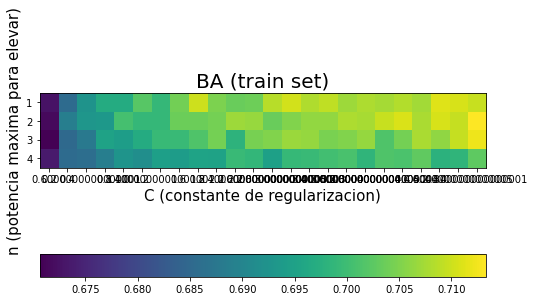

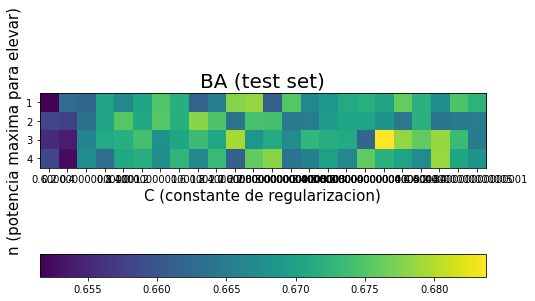

In [52]:

fig, ax = plt.subplots(1,1, figsize=(8,8))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo 
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(8,8)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = c_values
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)
